In [ ]:
sheet_id = "1KGICaTvObgaS4aFhk85vmrnnV0DT5lv9wkyvY-InzTE"
worksheet_name = "Sheet1"

In [ ]:
!pip install --upgrade gspread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2


In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth

In [ ]:
auth.authenticate_user()

In [ ]:
import gspread

In [ ]:
from google.auth import default

In [ ]:
creds, _ = default()

In [ ]:
gc = gspread.authorize(creds)

In [ ]:
sh = gc.open_by_key(sheet_id)

In [ ]:
sh.worksheets()

[<Worksheet 'Sheet1' id:0>]

In [ ]:
worksheet = sh.worksheet(worksheet_name)

In [ ]:
worksheet.get_all_records()

[{'Model': 1,
  'LR': 0.001,
  'factor': 0.1,
  'patience': 5,
  'Validation accuracy': '90%',
  'Diabetes Accuracy': '80%',
  '': ''},
 {'Model': 2,
  'LR': 0.0001,
  'factor': 0.1,
  'patience': 5,
  'Validation accuracy': '88%',
  'Diabetes Accuracy': '91%',
  '': ''},
 {'Model': 3,
  'LR': 0.0001,
  'factor': 0.9,
  'patience': 10,
  'Validation accuracy': '87%',
  'Diabetes Accuracy': '93%',
  '': ''},
 {'Model': 4,
  'LR': 1e-05,
  'factor': 0.1,
  'patience': 1,
  'Validation accuracy': '94%',
  'Diabetes Accuracy': '69%',
  '': ''},
 {'Model': 5,
  'LR': 0.002,
  'factor': 0.5,
  'patience': 5,
  'Validation accuracy': '87%',
  'Diabetes Accuracy': '92%',
  '': ''},
 {'Model': 6,
  'LR': 0.0001,
  'factor': 0.1,
  'patience': 1,
  'Validation accuracy': '88.5%',
  'Diabetes Accuracy': '89.0%',
  '': ''},
 {'Model': 7,
  'LR': 0.00603,
  'factor': 0.1549132812,
  'patience': 9,
  'Validation accuracy': '86.0%',
  'Diabetes Accuracy': '93.0%',
  '': ''},
 {'Model': 8,
  'LR': 0.0

In [ ]:
df = pd.DataFrame(worksheet.get_all_records())

In [ ]:
df

,Model,LR,factor,patience,Validation accuracy,Diabetes Accuracy
0,1,0.00100,0.1,5,90%,80%
1,2,0.00010,0.1,5,88%,91%
2,3,0.00010,0.9,10,87%,93%
3,4,0.00001,0.1,1,94%,69%
4,5,0.00200,0.5,5,87%,92%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import andrews_curves
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import accuracy_score

path_train = '/content/drive/MyDrive/Data/train_data.csv'
train_df = pd.read_csv(path_train)

path_val = '/content/drive/MyDrive/Data/val_data.csv'
val_df = pd.read_csv(path_val)

In [ ]:
X = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
y = ['diabetes']

X_train = train_df[X]
print('X_train, our input variables:')
print(X_train.head())
print()

y_train = train_df[y]
print('y_train, our output variable:')
print(y_train.head())

X_train, our input variables:
    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level
0  36.0             0              0  17.06          4.0                  145
1  58.0             0              0  37.83          6.1                  159
2  43.0             0              0  39.20          5.0                  160
3  67.0             1              0  28.39          5.7                  159
4   5.0             0              0  27.32          6.0                   80

y_train, our output variable:
   diabetes
0         0
1         0
2         0
3         0
4         0


In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
X_val = val_df[X]
y_val = val_df[y]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
scaler = StandardScaler()
X_adasyn_scaled = scaler.fit_transform(X_adasyn)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Convert pandas DataFrames to PyTorch tensors
X_adasyn_tensor = torch.tensor(X_adasyn_scaled, dtype=torch.float32)
y_adasyn_tensor = torch.tensor(y_adasyn.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [ ]:
class DiabetesPredictionModel(nn.Module):
    def __init__(self, input_size):
        super(DiabetesPredictionModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )

        # Calculate the output size of the convolutional layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_size)
            conv_output_size = self._get_conv_output_size(dummy_input)

        self.linear_stack = nn.Sequential(
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )

    def _get_conv_output_size(self, x):
        x = self.conv_stack(x)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.conv_stack(x)
        logits = self.linear_stack(x)
        return logits

In [ ]:
# Define custom dataset for training and testing
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [ ]:
import os
from google.colab import files

In [ ]:
os.makedirs('/content/drive/MyDrive/Models', exist_ok=True)

In [ ]:
# Create data loaders for training and validation
adasyn_dataset = DiabetesDataset(X_adasyn_tensor.unsqueeze(1), y_adasyn_tensor)  # Add an extra dimension for input channels
val_dataset = DiabetesDataset(X_val_tensor.unsqueeze(1), y_val_tensor)  # Add an extra dimension for input channels
adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import random

max_list_length = 10

# Define the run_model_experiment function
def run_model_experiment(experiment_number):
    # Generate random learning rate, factor, and patience values
    lr = random.uniform(1e-5, 1e-2)
    hyp1 = random.uniform(0.05, 0.9)
    hyp2 = random.randint(1, 10)

    # Instantiate the model
    input_size = X_adasyn_tensor.shape[1]
    model = DiabetesPredictionModel(input_size)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=hyp1, patience=hyp2, verbose=True)

    num_epochs = 5
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in adasyn_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(adasyn_dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.squeeze())
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataset)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'/content/drive/MyDrive/Models/model_{experiment_number}.pt')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")

    model.load_state_dict(torch.load(f'/content/drive/MyDrive/Models/model_{experiment_number}.pt'))

    model.eval()
    with torch.no_grad():
        y_pred_adasyn = (model(X_adasyn_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()
        y_pred_val = (model(X_val_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()

    val_accuracy = round(accuracy_score(y_val, y_pred_val) * 100, 1)

    # Calculate diabetes prediction accuracy
    cm_val = confusion_matrix(y_val, y_pred_val)

    diabetes_accuracy_val = round(cm_val[1][1] / (cm_val[1][1] + cm_val[1][0]) * 100, 1)

    print("Val Accuracy:", val_accuracy)

    print("Val Diabetes Accuracy:", diabetes_accuracy_val)

    # Format lr and accuracies for Google Sheets
    lr_str = "{:.2E}".format(lr)
    val_accuracy_str = str(val_accuracy) + '%'
    diabetes_accuracy_val_str = str(diabetes_accuracy_val) + '%'

    # Add experiment details to Google Sheets
    worksheet.append_row([experiment_number, lr_str, hyp1, hyp2, val_accuracy_str, diabetes_accuracy_val_str])

adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Run experiments
experiment_number = 71
for _ in range(max_list_length):
    run_model_experiment(experiment_number)
    experiment_number += 1


Epoch 1/5, Train Loss: 0.30, Val Loss: 0.30
Epoch 2/5, Train Loss: 0.28, Val Loss: 0.28
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 4/5, Train Loss: 0.28, Val Loss: 0.24
Epoch 5/5, Train Loss: 0.28, Val Loss: 0.31
Val Accuracy: 89.3
Val Diabetes Accuracy: 90.9
Epoch 1/5, Train Loss: 0.29, Val Loss: 0.24
Epoch 2/5, Train Loss: 0.28, Val Loss: 0.24
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 00004: reducing learning rate of group 0 to 1.9862e-03.
Epoch 4/5, Train Loss: 0.27, Val Loss: 0.28
Epoch 5/5, Train Loss: 0.27, Val Loss: 0.28
Val Accuracy: 89.4
Val Diabetes Accuracy: 86.5
Epoch 1/5, Train Loss: 0.30, Val Loss: 0.27
Epoch 2/5, Train Loss: 0.29, Val Loss: 0.34
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.24
Epoch 4/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 5/5, Train Loss: 0.28, Val Loss: 0.27
Val Accuracy: 87.7
Val Diabetes Accuracy: 90.2
Epoch 1/5, Train Loss: 0.29, Val Loss: 0.33
Epoch 2/5, Train Loss: 0.28, Val Loss: 0.29
Epoch 3/5, Train Loss: 0.28, Val Loss: 0.25
Epoch

In [ ]:
# Creating data loaders for training and validation
adasyn_dataset = DiabetesDataset(X_adasyn_tensor.unsqueeze(1), y_adasyn_tensor)
val_dataset = DiabetesDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Instantiating the model
input_size = X_adasyn_tensor.shape[1]
model = DiabetesPredictionModel(input_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=10, verbose=True)

In [ ]:
#Training and testing model
num_epochs = 5
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in adasyn_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        loss.backward()

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(adasyn_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_dataset)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Loading the best model for predictions
model.load_state_dict(torch.load('best_model.pt'))


Epoch 1/5, Train Loss: 0.3380, Val Loss: 0.3116
Epoch 2/5, Train Loss: 0.2850, Val Loss: 0.2659
Epoch 3/5, Train Loss: 0.2738, Val Loss: 0.3047
Epoch 4/5, Train Loss: 0.2680, Val Loss: 0.2850
Epoch 5/5, Train Loss: 0.2642, Val Loss: 0.2852


<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_adasyn = (model(X_adasyn_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()
    y_pred_val = (model(X_val_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()

adasyn_accuracy = accuracy_score(y_adasyn, y_pred_adasyn)
val_accuracy = accuracy_score(y_val, y_pred_val)

print("ADASYN Accuracy:", adasyn_accuracy)
print("Val Accuracy:", val_accuracy)


ADASYN Accuracy: 0.8711915902047761
Val Accuracy: 0.8766


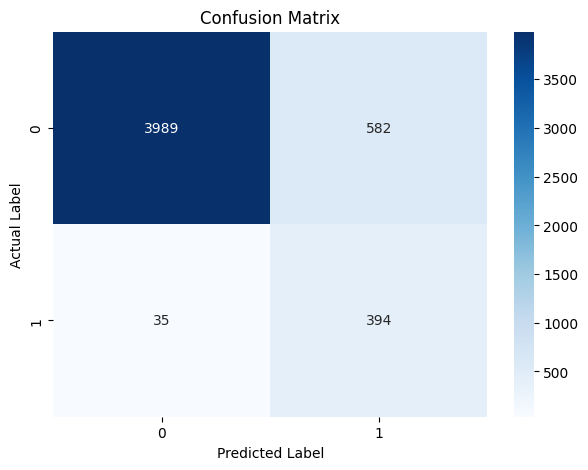

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_val)

cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import pickle

# Assuming you have trained your model and it's stored in the variable `DiabetesPredictionModel`
# Save the model to a .h5 file using pickle
with open('/content/drive/MyDrive/Data/model.pkl', 'wb') as file:
    pickle.dump(DiabetesPredictionModel, file)
